In [1]:
from migration_process import *
import numpy as np
import matplotlib.pyplot as plt
from parameters import *

# Projet de FAT : Simulation d'un réseau de Vélib

Adrien BLASSIAU

Corentin JUVINGY

MPRO - 2019

# 1. Modélisation Markovienne du problème

## 1.1 Rappel des consignes

Tout d'abord rappelons les consignes du problème avec les notations utilisées :

* On s'intéresse à $N$ stations Vélib qui contiennent respectivement $v_{i}$, $i\in\{1,\ldots,N\}$ places.
Il y a $K\leq\sum_{i=1}^{N} v_{i}$ vélos dans le système.
* Des vélos se déplacent entre ces stations. Aucun vélo ne vient de l'extérieur, le système est donc **fermé**.

* On dispose des **paramètres** suivants :
    - $\forall i\in\{1,\ldots,N\}$, $\lambda_{i}$ **correspond à l'intensité des occurrences de demande de vélos à la station $\mathbf{i}$**.
    - $\forall i,j \in\{1,\ldots,N\}$ tels que $i \neq j$, **le temps de trajet en vélo de la station $\mathbf{i}$ à la station $\mathbf{j}$** $\sim \mathcal{E}(\lambda_{ij})$. Attention, $\lambda_{ij}\neq\lambda_{ji}$ en général.
    - une matrice de routage $P$ carrée de taille $N$, avec $\forall i, \sum_{j=1}^{N} p_{ij}=1$ (elle est donc stochastique) où $\forall i,j$, $\mathbf{p_{ij}}$ **est interprété comme la probabilité d'aller vers $\mathbf{j}$ pour un vélo qui part de la station $\mathbf{i}$**.
 
* On fait **hypothèses** suivantes :
    - Il n'y a **pas de boucle**, donc $\forall i,p_{ii}=0$
    - Si un vélo trouve la station d'arrivée $j$ pleine, on tire au sort une nouvelle station d'arrivée $k$ suivant $p_{jk}$ où $k \in\{1,\ldots,N\}$ avec $k \neq j$
    - Si une requête à la station $i$ ne trouve pas de vélo, elle est perdue.
 
## 1.2 Modélisation

### 1.2.1 Espace d'états


On représente notre système par un ensemble de $N^{2}$ noeuds de deux types :

* $N$ noeuds représentent les stations de Vélib, ils sont de la forme $n_{ii}, \forall i\in\{1,\ldots,N\}$.
* $N(N-1)$ noeuds représentant les itinéraires d'une station vers une autre, ils sont de la forme $n_{ij}, \forall i,j\in\{1,\ldots,N\}$ tels que $i \neq j$.

On s'inspire du chapitre *sur les colonies* issu du livre de Kelly pour la modélisation Markovienne. Une **colonie** est ici un noeud de notre graphe, donc une station ou un itinéraire, et un **individu** est un vélo.

L'espace des état est :

$$S= \{(n_{ij})_{i,j\in\{1,\ldots,N\}} \in \{0,\ldots,K\}^{N^2} :  \sum_{i=1}^{N}\sum_{j=1}^{N}n_{ij}=K \wedge \forall i\in\{1,\ldots,N\}, n_{ii} \le v_{i}\}$$

Ainsi :
* chaque état est noté $n=(n_{11},n_{12},...,n_{NN})$ où $n_{ij}$ correspond au nombre de vélos dans l'état correspondant
* $\sum_{i=1}^{N}\sum_{j=1}^{N}n_{ij}=K \wedge \forall i\in\{1,\ldots,N\}, n_{ii} \le v_{i}\}$ sont les deux **contraintes de capacité** qui formalisent le fait que le nombre de vélos total est $K$ et que chaque station ne doit pas stocker plus de vélos qu'elle n'a de place

Enfin, pour résumer, on quitte une station $n_{ii}$ en suivant une loi exponentielle de paramètre $\lambda_{i}$, on choisit une station d'arrivée $n_{jj}$ avec une probabilité $p_{ij}$ puis on se retrouve dans l'itinéraire vers la station $n_{jj}$ que l'on quitte selon une loi exponenetielle de paramètre $\lambda_{ij}$.

### 1.2.2 Générateur infinitésimal

Soit $n_{k}$ et $n_{l}$ deux noeuds distincts, $i,j\in\{1,\ldots,N\} \mbox{ avec } i \neq j$. Tout comme Kelly, on définit un opérateur $T_{kl}$ qui formalise soit :

* le **départ d'un vélo d'une station** $n_{ii}$ **vers un itinéraire** $n_{ij}$. Dans ce cas, $n_{k}$ est une station et $k=(ii)$ ; $n_{l}$ est un itinéraire et $l=(ij)$.
* l'**arrivée d'un vélo dans une station** $n_{jj}$ **venant d'un itinéraire** $n_{ij}$, si $n_{jj} < v_{j}$. Dans ce cas, $n_{k}$ est un itinéraire et $k=(ij)$ ; $n_{l}$ est une station et $l=(jj)$.
* l'**arrivée d'un vélo dans un itinéraire** $n_{jm}$ **venant d'un itinéraire** $n_{ij}$, si $n_{jj} = v_{j}$. Dans ce cas, $n_{k}$ est un itinéraire et $k=(ij)$ ; $n_{l}$ est un itinéraire et $l=(jm)$.

$T_{kl}(n_{11},n_{12},\ldots,n_{NN}) =$

$$
\left\{
    \begin{array}{ll}
        T_{kl}(n_{11},n_{12},\ldots,n_{k}-1,\ldots,n_{l}+1,\ldots,n_{NN}), \quad \mbox{ si } k=(ii), l=(ij) \mbox{ et }  i<j \\
        T_{kl}(n_{11},n_{12},\ldots,n_{l}+1,\ldots,n_{k}-1,\ldots,n_{NN}), \quad \mbox{ si } k=(ii), l=(ij) \mbox{ et }  i>j \\
        T_{kl}(n_{11},n_{12},\ldots,n_{k}-1,\ldots,n_{l}+1,\ldots,n_{NN}), \quad \mbox{ si } k=(ij), l=(jj) \mbox{ et }  i<j \mbox{ et } n_{jj} < v_{j}\\
        T_{kl}(n_{11},n_{12},\ldots,n_{l}+1,\ldots,n_{k}-1,\ldots,n_{NN}), \quad \mbox{ si } k=(ij), l=(jj) \mbox{ et }  i>j \mbox{ et } n_{jj} < v_{j}\\
        T_{kl}(n_{11},n_{12},\ldots,n_{k}-1,\ldots,n_{l}+1,\ldots,n_{NN}), \quad \mbox{ si } k=(ij), l=(jm) \mbox{ et }  i>j \mbox{ et } n_{jj} = v_{j}\\
        T_{kl}(n_{11},n_{12},\ldots,n_{l}+1,\ldots,n_{k}-1,\ldots,n_{NN}), \quad \mbox{ si } k=(ij), l=(jm) \mbox{ et }  i<j \mbox{ et } n_{jj} = v_{j}\\
    \end{array}
\right.
$$

Définissons maintenant les taux de transition qui forment les coefficients du générateur infinitésimal, en utilisant la méthode proposée par Kelly.
Une transition ne peut avoir lieu qu'entre un état $n$ et un état $T_{kl}(n)$, où $n_{k}$ et $n_{l}$ sont deux noeuds distincts.
On considère que les taux de transition ont la forme suivante : $q(n,T_{kl}(n)) = \Lambda_{kl}\phi_{k}(n_{k})$. On distingue les trois cas vus plus haut : 

* le **départ d'un vélo d'une station** $n_{ii}$ **vers un itinéraire** $n_{ij}$. Dans ce cas, $n_{k}$ est une station et $k=(ii)$ ; $n_{l}$ est un itinéraire et $l=(ij)$. On a : 
    * $\Lambda_{kl}=\lambda_{i}*p_{ij}$ où $\lambda_{i}$ et $p_{ij}$ sont donnés dans l'énoncé
    * $\phi_{k}(n_{k})=min(n_{ii},1)$ (1 car une station a un serveur)
    * **donc** 
 $$
     q(n,T_{kl}(n)) = \lambda_{i}*p_{ij}*min(n_{ii},1)
 $$
 
* l'**arrivée d'un vélo dans une station** $n_{jj}$ **venant d'un itinéraire** $n_{ij}$, si $n_{jj} < v_{j}$. Dans ce cas, $n_{k}$ est un itinéraire et $k=(ij)$ ; $n_{l}$ est une station et $l=(jj)$. On a :
    * $\Lambda_{kl}$ = $\lambda_{ij}*p_{ij}=\lambda_{ij}$ où $\lambda_{ij}$ est donné dans l'énoncé et $p_{ij}=1$ car on sait déjà où l'on va.
    * $\phi_{k}(n_{k})=min(n_{ij},K)= n_{ij}$ car on ne peut pas avoir plus de vélos sur un itinéraire que le nombre de vélos total ($K$ car un itinéraire à une infinité de serveur, on prend K le nombre total de vélos)
    * **donc** 
    $$
    q(n,T_{kl}(n)) = \lambda_{ij}*n_{ij} 
    $$
 
* l'**arrivée d'un vélo dans un itinéraire** $n_{jm}$ **venant d'un itinéraire** $n_{ij}$, si $n_{jj} = v_{j}$. Dans ce cas, $n_{k}$ est un itinéraire et $k=(ij)$ ; $n_{l}$ est un itinéraire et $l=(jm)$. On a :
    * $\Lambda_{kl}$ = $\lambda_{ij}*p_{ij}*p_{jm}=\lambda_{ij}*p_{jm}$ où $\lambda_{ij}$ est donné dans l'énoncé, $p_{ij}=1$ car on sait déjà où l'on va et la station $n_{jj}$ étant remplie, on tire une nouvelle station m avec une probabilité $p_{jm}$.
    * $\phi_{k}(n_{k})=min(n_{ij},K)= n_{ij}$ car on ne peut pas avoir plus de vélos sur un itinéraire que le nombre de vélos total ($K$ car un itinéraire à une infinité de serveur, on prend K le nombre total de vélos)
    * **donc** 
    $$
    q(n,T_{kl}(n)) = \lambda_{ij}*n_{ij}*p_{jm}.
    $$

### 1.2.3 Probabilité stationnaire


**Existence :**

L’unique probabilité stationnaire $\pi$ du processus $X$ sur $S$, si elle existe, vérifie le système matriciel $πA=0$ où A est le générateur infinitésimal.
L'existence est assurée si :
* Le processus doit être est irréductible, c'est-à-dire si tout état est accessible à partir de n'importe quel autre état en un nombre fini d'itérations. **C'est triviallement le cas ici**.
* L'espace d'états doit être fini. On rappelle que l'on a :
$$
S= \{(n_{ij})_{i,j\in\{1,\ldots,N\}} \in \{0,\ldots,K\}^{N^2} :  \sum_{i=1}^{N}\sum_{j=1}^{N}n_{ij}=K \wedge \forall i\in\{1,\ldots,N\}, n_{ii} \le v_{i}\}
$$
Le cardinal de cet ensemble est borné par $(K+1)^{N^2}$, il est donc fini.

**Expression :**

Pour déterminer l'expression de la probabilité stationnaire, on utilise les équations de trafic données par Kelly pour tout d'abord déterminer les $\alpha_{ij}$ (on se place dans le cas particulier d'un système à un individu, comme Kelly). On obtient les deux équations suivantes :

\begin{align}
    \forall i,\quad & \alpha_{(ii)}\sum_{j\neq i}^{}\Lambda_{(ii),(ij)} = \sum_{j\neq i}^{}\alpha_{(ji)}\Lambda_{(ji),(ii)}\\ 
    \forall i\neq j,\quad & \alpha_{(ij)}\Lambda_{(ij),(jj)} = \alpha_{(ii)}\Lambda_{(ii),(ij)}
\end{align}

qui donne : 

\begin{align}
    \forall i,\quad & \alpha_{(ii)}\sum_{j\neq i}^{}\lambda_{i}p_{ij} = \sum_{j\neq i}^{}\alpha_{(ji)}\lambda_{ji}\\ 
    \forall i\neq j,\quad & \alpha_{(ij)}\lambda_{ij} = \alpha_{(ii)}\lambda_{i}p_{ij}
\end{align}

en enfin, en considérant que $\sum_{j\neq i}^{}p_{ij}=1$ et en inversant $i$ et $j$ dans (4):

\begin{align}
    \forall i,\quad & \alpha_{(ii)}\lambda_{i} = \sum_{j\neq i}^{}\alpha_{(ji)}\lambda_{ji}\\ 
    \forall i\neq j,\quad & \alpha_{(ji)}\lambda_{ji} = \alpha_{(jj)}\lambda_{j}p_{ji}
\end{align}

En injectant (6) dans (5) et en posant $\alpha_{ii}=\alpha_{i}$ on obtient :

\begin{align}
    \forall i,\quad & \alpha_{i} = \frac{1}{\lambda_{i}}\sum_{j\neq i}^{}\alpha_{j}\lambda_{j}p_{ji}
\end{align}

De plus, on a la contrainte suivante, sachant que $\forall i, \alpha_{i} > 0  \mbox{ et avec } i\neq j, \alpha_{(ij)} > 0$: 

\begin{align}
    \sum_{i}^{} \alpha_{i} + \sum_{i}^{}\sum_{j\neq i}^{} \alpha_{(ij)} = 1
\end{align}

qui devient, en utilisant (4)

\begin{align}
    \sum_{i}^{} \alpha_{i} + \sum_{i}^{}\sum_{j\neq i}^{} \frac{\alpha_{i}\lambda_{i}p_{ij}}{\lambda_{ij}} = 1
\end{align}

donc, on obtient, après inversion de i et j : 
\begin{align}
    \sum_{j}^{}\left( 1 + \lambda_{j}\sum_{i\neq j}^{} \frac{p_{ji}}{\lambda_{ji}}\right)\alpha_{j} = 1
\end{align}
On peut maintenant réécrire (7) matriciellement, en utilisant (10) :
\begin{align}
    (P-I)\alpha=X
\end{align}
où $P$ et la matrice dont les coefficients sont les $\left(\frac{\lambda_{j}p_{ji}}{\lambda_{i}}\right)_{i,j\in\{1,\ldots,N\}}$.

Pour éviter d'obtenir la solution nulle, on remplace la première ligne de $(P-I)$ par $\left( 1 + \lambda_{j}\sum_{i\neq j}^{} \frac{p_{ji}}{\lambda_{ji}}\right)_{j\in\{1,\ldots,N\}}$ et la première ligne de $X$ par 1.

**On obtient les $\alpha_{i}$ en résolvant ce système. Pour obtenir les $\alpha_{ij}$, on utilise (4).**

Notre probabilité stationnaire est finalement obtenue en utilisant la formule du Théorème 2.4 de Kelly : 

\begin{align}
    \pi(n) = G_{K}^{-1}\prod_{i=1}^{N}\prod_{j=1}^{N}\frac{\alpha_{ij}^{n_{ij}}}{\prod_{r=1}^{n_{ij}}\phi_{ij}(r)},\quad & n \in S
\end{align}
où $G_{N}$ peut être obtenue en considérant que $\sum_{n\in S}^{}\pi(n)=1$.

# 2. Calibration des paramètres

Nous calculons maintenant les valeurs des paramètres $\lambda_{i}$, $\lambda_{i,j}$ et $q_{i,j}$ à l'aide des données du réseau de Rouen.

Pour cela on dispose de deux fichiers contenant respectivement le nombre moyen de départs et d'arrivées à chacune des stations de Rouen et le temps de trajet moyen entre ces stations.

## 2.1 $\lambda_i$

Les $\lambda_i$ correspondent à l’intensité des occurrences de la demande de vélos à la station i. On suppose qu'elles suivent une loi de Poisson, d'où $\mathbb{E}[X_i] = \lambda_i$. On les trouve à partir du nombre moyen de départs en une heure. Ainsi on obtient :

| N° station | $\lambda_i$ (1/min) |
|------------|---------------------|
| 1          | 1.02                |
| 2          | 3.58                |
| 3          | 4.30                |
| 4          | 5.68                |
| 5          | 8.49                |
| 6          | 5.33                |
| 7          | 7.03                |
| 8          | 2.97                |
| 9          | 2.50                |
| 10         | 2.08                |
| 11         | 2.35                |
| 12         | 1.82                |
| 13         | 3.77                |
| 14         | 2.77                |
| 15         | 2.13                |
| 16         | 3.6                 |
| 17         | 1.67                |
| 18         | 1.08                |
| 19         | 1.7                 |
| 20         | 1.6                 |
| 21         | 2.03                |


## 2.2 $\lambda_{ij}$

Les $\lambda_{ij}$ correspondent au temps de trajet en vélo de la $i^{ème}$ à la $j^{ème}$ station. On les obtient à partir du tableau contenant l'ensemble des temps de trajets entre chacune des stations. On utilise le faite que les temps de trajets suivent une loi exponentielle $\epsilon(\lambda_{ij})$. On en déduit donc que $\mathbb{E}[X] = \frac{1}{\lambda_{ij}}$. D'où $\lambda_{ij} = \frac{1}{\mathbb{E}[X_{ij}]} = \frac{1}{temps\ moyen\ pour\ aller\ de\ i\ en\ j}$ (Les $\lambda_{ii}$ ont pour valeur -1 car il ne peut y avoir un trajet d'un station à elle même).

|  λij | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
|  1 | -1 | 0,2 | 1 | 0,5 | 0,3333333333 | 0,1666666667 | 0,1666666667 | 0,25 | 0,3333333333 | 0,2 | 0,2 | 0,1428571429 | 0,1428571429 | 0,1 | 0,25 | 0,1111111111 | 0,1 | 0,1 | 0,08333333333 | 0,09090909091 | 0,1 |
|  2 | 0,1428571429 | -1 | 0,1666666667 | 0,125 | 0,1 | 0,06666666667 | 0,07142857143 | 0,09090909091 | 0,08333333333 | 0,125 | 0,125 | 0,1111111111 | 0,1111111111 | 0,08333333333 | 0,1 | 0,08333333333 | 0,09090909091 | 0,1666666667 | 0,07692307692 | 0,05 | 0,07692307692 |
|  3 | 1 | 0,2 | -1 | 0,3333333333 | 0,2 | 0,1428571429 | 0,1428571429 | 0,2 | 0,2 | 0,1428571429 | 0,1428571429 | 0,1111111111 | 0,1111111111 | 0,08333333333 | 0,1666666667 | 0,09090909091 | 0,09090909091 | 0,1 | 0,07692307692 | 0,07142857143 | 0,08333333333 |
|  4 | 0,5 | 0,1666666667 | 0,5 | -1 | 0,5 | 0,2 | 0,2 | 0,25 | 0,25 | 0,1666666667 | 0,1666666667 | 0,1111111111 | 0,125 | 0,09090909091 | 0,25 | 0,1 | 0,08333333333 | 0,09090909091 | 0,07692307692 | 0,1 | 0,09090909091 |
|  5 | 0,3333333333 | 0,125 | 0,25 | 0,5 | -1 | 0,3333333333 | 0,3333333333 | 0,5 | 0,3333333333 | 0,1428571429 | 0,1428571429 | 0,1 | 0,125 | 0,08333333333 | 0,1666666667 | 0,1111111111 | 0,07692307692 | 0,07692307692 | 0,07692307692 | 0,125 | 0,09090909091 |
|  6 | 0,1428571429 | 0,07692307692 | 0,125 | 0,1666666667 | 0,25 | -1 | 0,5 | 0,3333333333 | 0,1666666667 | 0,1 | 0,1 | 0,07142857143 | 0,08333333333 | 0,06666666667 | 0,1111111111 | 0,08333333333 | 0,0625 | 0,05882352941 | 0,05882352941 | 0,1666666667 | 0,06666666667 |
|  7 | 0,125 | 0,08333333333 | 0,1428571429 | 0,1428571429 | 0,2 | 0,5 | -1 | 0,5 | 0,25 | 0,1111111111 | 0,1111111111 | 0,08333333333 | 0,1 | 0,07142857143 | 0,1 | 0,09090909091 | 0,06666666667 | 0,0625 | 0,06666666667 | 0,1428571429 | 0,07142857143 |
|  8 | 0,2 | 0,1111111111 | 0,2 | 0,2 | 0,25 | 0,3333333333 | 0,5 | -1 | 0,5 | 0,1428571429 | 0,1428571429 | 0,1 | 0,1111111111 | 0,08333333333 | 0,125 | 0,1111111111 | 0,07692307692 | 0,07142857143 | 0,07692307692 | 0,1111111111 | 0,08333333333 |
|  9 | 0,25 | 0,1111111111 | 0,25 | 0,2 | 0,2 | 0,25 | 0,3333333333 | 1 | -1 | 0,1428571429 | 0,1428571429 | 0,1111111111 | 0,125 | 0,1 | 0,125 | 0,1428571429 | 0,09090909091 | 0,08333333333 | 0,08333333333 | 0,1 | 0,09090909091 |
|  10 | 0,1428571429 | 0,1 | 0,1428571429 | 0,1428571429 | 0,1111111111 | 0,1 | 0,1428571429 | 0,1666666667 | 0,1428571429 | -1 | 2 | 0,2 | 0,5 | 0,2 | 0,09090909091 | 0,2 | 0,1666666667 | 0,07142857143 | 0,1666666667 | 0,0625 | 0,2 |
|  11 | 0,1428571429 | 0,1 | 0,1428571429 | 0,1428571429 | 0,1111111111 | 0,1 | 0,1428571429 | 0,1666666667 | 0,1428571429 | 2 | -1 | 0,2 | 0,5 | 0,2 | 0,09090909091 | 0,2 | 0,1666666667 | 0,07142857143 | 0,1666666667 | 0,0625 | 0,2 |
|  12 | 0,1428571429 | 0,1 | 0,125 | 0,1111111111 | 0,09090909091 | 0,08333333333 | 0,1 | 0,1111111111 | 0,1428571429 | 0,3333333333 | 0,3333333333 | -1 | 0,3333333333 | 0,1666666667 | 0,09090909091 | 0,125 | 0,25 | 0,07142857143 | 0,1666666667 | 0,05882352941 | 0,1666666667 |
|  13 | 0,1428571429 | 0,1111111111 | 0,1111111111 | 0,1111111111 | 0,1 | 0,1 | 0,125 | 0,125 | 0,1111111111 | 0,5 | 0,5 | 0,3333333333 | -1 | 0,3333333333 | 0,09090909091 | 0,1428571429 | 0,25 | 0,07142857143 | 0,2 | 0,0625 | 0,25 |
|  14 | 0,1 | 0,07692307692 | 0,09090909091 | 0,09090909091 | 0,07692307692 | 0,08333333333 | 0,09090909091 | 0,1111111111 | 0,1428571429 | 0,25 | 0,25 | 0,2 | 0,3333333333 | -1 | 0,07142857143 | 0,125 | 0,2 | 0,0625 | 0,25 | 0,05555555556 | 0,5 |
|  15 | 0,2 | 0,1428571429 | 0,25 | 0,3333333333 | 0,2 | 0,125 | 0,125 | 0,1428571429 | 0,1428571429 | 0,1111111111 | 0,1111111111 | 0,09090909091 | 0,09090909091 | 0,07142857143 | -1 | 0,07142857143 | 0,07692307692 | 0,07692307692 | 0,06666666667 | 0,08333333333 | 0,07142857143 |
|  16 | 0,1428571429 | 0,08333333333 | 0,125 | 0,125 | 0,1111111111 | 0,1111111111 | 0,1428571429 | 0,1666666667 | 0,25 | 0,1428571429 | 0,1428571429 | 0,09090909091 | 0,125 | 0,08333333333 | 0,09090909091 | -1 | 0,08333333333 | 0,0625 | 0,08333333333 | 0,07142857143 | 0,09090909091 |
|  17 | 0,08333333333 | 0,07142857143 | 0,08333333333 | 0,07692307692 | 0,06666666667 | 0,06666666667 | 0,07142857143 | 0,08333333333 | 0,09090909091 | 0,1666666667 | 0,1666666667 | 0,2 | 0,1666666667 | 0,2 | 0,0625 | 0,08333333333 | -1 | 0,05882352941 | 0,3333333333 | 0,04761904762 | 0,1428571429 |
|  18 | 0,1 | 0,1666666667 | 0,1111111111 | 0,08333333333 | 0,07692307692 | 0,05882352941 | 0,0625 | 0,07142857143 | 0,08333333333 | 0,1 | 0,1 | 0,09090909091 | 0,08333333333 | 0,06666666667 | 0,07142857143 | 0,07142857143 | 0,07692307692 | -1 | 0,06666666667 | 0,04347826087 | 0,06666666667 |
|  19 | 0,08333333333 | 0,07142857143 | 0,07692307692 | 0,07692307692 | 0,06666666667 | 0,06666666667 | 0,07692307692 | 0,08333333333 | 0,1 | 0,1666666667 | 0,1666666667 | 0,1666666667 | 0,2 | 0,25 | 0,0625 | 0,09090909091 | 0,5 | 0,05555555556 | -1 | 0,04761904762 | 0,1666666667 |
|  20 | 0,08333333333 | 0,05882352941 | 0,08333333333 | 0,1 | 0,125 | 0,1666666667 | 0,1666666667 | 0,1428571429 | 0,1111111111 | 0,06666666667 | 0,06666666667 | 0,05555555556 | 0,05882352941 | 0,05 | 0,08333333333 | 0,05882352941 | 0,04761904762 | 0,04761904762 | 0,04761904762 | -1 | 0,05 |
|  21 | 0,1 | 0,07142857143 | 0,09090909091 | 0,09090909091 | 0,09090909091 | 0,08333333333 | 0,1 | 0,125 | 0,1428571429 | 0,2 | 0,2 | 0,1428571429 | 0,25 | 0,25 | 0,07142857143 | 0,125 | 0,1428571429 | 0,05882352941 | 0,1428571429 | 0,05882352941 | -1 


## $p_{ij}$

Afin d'obtenir les valeurs des $p_{ij}$ nous sommes partis du tableau contenant le nombre moyen de départs et d'arrivées dans chaque station du réseau. Nous avons construit le programme linéaire suivant :

$$max\ \sum_{i = 1}^{N}{\sum_{j = 1}^{N}{p_{i,j}}}$$

sous les contraintes :
$$
\left\{
    \begin{array}{ll}
        \forall j \in \{1..N\},\quad \ & k_{min}Arr_{j} \leq \sum_{i = 1}^{N}{p_{i,j}d_i} \leq k_{max}Arr_{i,j} \\
        \forall i \in \{1..N\},\quad \ & \sum_{j = 0}^{N}{p_{i,j}} = 1 \\
        \forall i \in \{1..N\},\quad \ & p_{i,i} = 1 \\
        \forall i,j \in \{1..N\} \mbox{ avec } i \neq j,\quad \ &  0.01 \leq p_{i,j} \leq 1 \\
    \end{array}
\right.
$$

$Arr_j$ est le nombre moyen d'arrivée à la station $j$ et $d_i$ est le nombre moyen de départ en $i$.

La fonction objectif a été choisie de façon à maximiser les valeurs les plus élevées possibles de $p_{ij}$.

$k_{min}$ et $k_{max}$ sont des constantes permettant de prendre en compte le faite qu'étant donné que les valeurs que l'on a ne sont pas des valeurs exactes mais des moyennes, l'équation $\forall j \in \{1..N\}\ \sum_{i = 1}^{N}{p_{i,j}d_i} = Arr_j$ est fausse.

Les résultats obtenus ne sont pas satisfaisant ; en effet le modèle PL renvoie des solutions mettant la plupart des valeurs à 0.01 et seulement deux ou trois à des valeurs acceptables. Il aurait fallu avoir des valeurs plus précises sur les nombres de départs et d'arrivées afin d'obtenir des résultats plus probant.


## 2.4 Paramètres calculés à partir du modèle réduit à 5 stations

À partir du modèle à 5 stations, on calcule les différents paramètres dont notre modèle aura besoin pour simuler des trajectoires. Tout ces paramètres sont stockés dans un objet de type **MigrationProcess**. Voici son contenu lors de son initialisation :

In [2]:
process = MigrationProcess(number_of_stations,
                           number_of_bikes,
                           initial_time,
                           lambda_station_matrix,
                           lambda_station_list_per_mins,
                           lambda_itinerary_matrix,                           
                           routing_matrix,
                           station_size_list)

process.print_process()

Nombre de stations : 5
Nombre de vélos dans le réseau : 80
Temps initial : 0.0
Intensité des occurences de demande de vélos à la station i (1/min) : 
[ 0.04666667  0.06166667  0.09166667  0.05833333  0.07666667]
Intensité des trajets en vélo de la station i à la station j (1/min) : 
[[ 0.          0.33333333  0.2         0.14285714  0.14285714]
 [ 0.5         0.          0.5         0.2         0.2       ]
 [ 0.25        0.5         0.          0.33333333  0.33333333]
 [ 0.125       0.16666667  0.25        0.          0.5       ]
 [ 0.14285714  0.14285714  0.2         0.5         0.        ]]
Matrice de routage : 
[[ 0.    0.2   0.3   0.2   0.3 ]
 [ 0.2   0.    0.3   0.2   0.3 ]
 [ 0.2   0.25  0.    0.25  0.3 ]
 [ 0.15  0.2   0.3   0.    0.35]
 [ 0.2   0.25  0.35  0.2   0.  ]]
Nombre de places par station : 
[24 20 20 15 20]
État courant (nombre de vélos par colonie), généré aléatoirement à l'initialisation: 
[[ 3.  3.  3.  5.  5.]
 [ 5.  3.  5.  3.  2.]
 [ 3.  3.  0.  2.  5.]
 [ 1.  7

# 3. Étude de la modélisation

Avant de commencer l'étude, on remarque que les états initiaux sont générés aléatoirement 
par la fonction **init_state_matrix**, tout en respectant les différentes contraintes de capacité.

## 3.1 Étude avec 1 vélo

On commence par le cas trivial de 1 vélo en partage sur les 5 stations. L'espace des états est ici : 
$$S= \{(n_{ij})_{i,j\in\{1,\ldots,N\}} \in \{0,\ldots,K\}^{N^2} :  \sum_{i=1}^{N}\sum_{j=1}^{N}n_{ij}=1 \wedge \forall i\in\{1,\ldots,N\}, n_{ii} \le v_{i}\}$$

Le vélo circule entre les stations et les itinéraires. Ainsi, il y a autant d'états que de possibilité de remplir une des colonies par un vélo donc $N^2$ états. Ici, on s'intéresse à une modélisation à 5 stations donc 25 états : $\{(1,0,0,\ldots),(0,1,0,\ldots),(0,0,1,\ldots),\ldots \}$. L'expression des $\alpha_{ij}$ a été obtenue dans la section **Probabilité stationnaire** plus haut.

Exprimons maintenant la probabilité stationnaire dans ce cas précis, en utilisant la formule donnée par Kelly.

Déterminons en premier le facteur $G_{1}$. Soit $n=(n_{11},\ldots,n_{kl},\ldots,n_{NN})$ un état quelconque tel que le vélo se trouve dans la colonie $n_{kl}$. On trouve, après simplification de l'expression de la probabilité stationnaire de Kelly, $\pi(n) = G_{1}^{-1}\alpha_{kl}$. 

Ainsi, $\forall n \in S$ : $\sum_{i=1}^{N}\sum_{j=1}^{N} \pi(n) = \sum_{i=1}^{N}\sum_{j=1}^{N} G_{1}^{-1} \alpha_{ij} = 1$, donc $G_{1} = \sum_{i=1}^{N}\sum_{j=1}^{N} \alpha_{ij}$.

On sait que la probabilité qu'une colonie $n_{kl}$ soit **pleine** est donnée par : $\pi(n) = G_{1}^{-1}\alpha_{kl}$, donc la probabilité qu'une colonie $n_{kl}$ soit **vide** est donnée par = $\pi(n) = 1 - G_{1}^{-1}\alpha_{kl}$

En utilisant cette formule, on obtient les **probabilités théoriques que chaque station soit vide** suivantes :

In [3]:
number_of_bikes = 1
process = MigrationProcess(number_of_stations,
                           number_of_bikes,
                           initial_time,
                           lambda_station_matrix,
                           lambda_station_list_per_mins,
                           lambda_itinerary_matrix,                           
                           routing_matrix,
                           station_size_list)

theory = process.compute_theorical_proba_emptiness()
theory

array([[ 0.82453272],
       [ 0.84449565],
       [ 0.86547538],
       [ 0.84433184],
       [ 0.84072577]])

On calcule maintenant de manière empirique la probabilité que chaque station soit vide. On lance 1000 simulations. Cette probabilité est calculée de deux manières différentes:

* En calculant la moyenne du pourcentage d'itérations où chaque station est vide durant les 150 heures de chaque simulation (méthode M1)
* En faisant la moyenne du nombre de fois où chaque station se retrouve vide à la fin des 150 heures du processus, donc après un temps long (méthode M2)

On obtient les **probabilités empiriques que chaque station soit vide** suivantes pour chaque méthode, avec les écarts de l'intervalle de confiance à 95% associés. Les intervalles de confiance sont en rose sur le graphique. 

       Stations     P Théorique  P Empirique M1       IC 95% M1  P Empirique M2       IC 95% M2
              1        0.824533        0.832089 [-0.016055;+0.016055] 1.000000 [-0.000000;+0.000000]
              2        0.844496        0.840269 [-0.002507;+0.002507] 0.800000 [-0.350615;+0.350615]
              3        0.865475        0.867937 [-0.008783;+0.008783] 0.800000 [-0.350615;+0.350615]
              4        0.844332        0.849095 [-0.009952;+0.009952] 0.800000 [-0.350615;+0.350615]
              5        0.840726        0.833136 [-0.015467;+0.015467] 1.000000 [-0.000000;+0.000000]


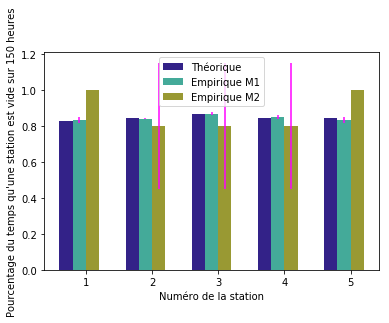

In [4]:
_ = MigrationProcess.estimate_time(5,T_max,process,theory,True) ## test with >= 100

On remarque que l'on obtient de **très bons résultats** pour la **méthode 1**, bien que les intervalles de confiance soient très **resserrés**. **Nos probabilités obtenues empiriquement coïncident avec les probabilités obtenues théoriquement**.

La **méthode 2** est de **moins bonne qualité**, ce qui était prévisible. Cependant, les intervalles de confiance sont **plus larges** ce qui permet de **coïncider** là encore avec les résultats obtenus **théoriquement** et de valider l'**ergodicité** du processus.

On peut remarquer que la durée indiquée de **150 heures semblent être convenable** pour atteindre la **probabilité stationnaire**.

## 3.2 Étude avec 100 vélos

On garde la même matrice de routage, les mêmes temps de transit, etc. En revanche, on suppose que l’on a 100 vélos dans le système.

L'espace des états est ici : 
$$S= \{(n_{ij})_{i,j\in\{1,\ldots,N\}} \in \{0,\ldots,K\}^{N^2} :  \sum_{i=1}^{N}\sum_{j=1}^{N}n_{ij}=100 \wedge \forall i\in\{1,\ldots,N\}, n_{ii} \le v_{i}\}$$

Cette fois ci, on remarque qu'il va être très difficile d'obtenir des résultats théoriques car **l'espace d'états est immense**, l'étude de la complexité va nous le confirmer.

On calculer par simulation la probabilité stationnaire pour chaque station d’être vide, en précisant les intervalles de confiance : 

In [5]:
number_of_bikes = 100
process = MigrationProcess(number_of_stations,
                           number_of_bikes,
                           initial_time,
                           lambda_station_matrix,
                           lambda_station_list_per_mins,
                           lambda_itinerary_matrix,                           
                           routing_matrix,
                           station_size_list)

_ = MigrationProcess.estimate_time(1,T_max,process,None,True)

       Stations  P Empirique M1       IC 95% M1  P Empirique M2       IC 95% M2
              1        0.000000 [-0.000000;+0.000000] 0.000000 [-0.000000;+0.000000]
              2        0.000000 [-0.000000;+0.000000] 0.000000 [-0.000000;+0.000000]
              3        0.000000 [-0.000000;+0.000000] 0.000000 [-0.000000;+0.000000]
              4        0.000000 [-0.000000;+0.000000] 0.000000 [-0.000000;+0.000000]
              5        0.000000 [-0.000000;+0.000000] 0.000000 [-0.000000;+0.000000]


La capacité totale de nos stations est de $24+20+20+15+20=99$ vélos. Avec 100 vélos dans le système, les stations sont très souvent remplies et quasiment jamais vide, car il est compliqué de vider une colonie avec une population initiale très importante et une matrice de routage avec des coefficients assez homogènes. Il est donc logique que la probabilité stationnaire recherchée soit presque nulle pour toutes les stations.

**Étude de la complexité :**

Notons $V_{i}$ l’ensemble des états où la station $i$ est vide. Pour 100 vélos et 5 stations, on cherche quelle serait la complexité du calcul de $\pi(V_{1})$ en termes de nombres d’opérations. Pour simplifier le calcul, on suppose que les stations ont une capacité infinie, tout comme les itinéraires. On peut donc placer tout les vélos sur une station ou un itinéraire.

On sait que le nombre de façon de répartir k éléments indiscernables dans n ensembles discernables, est donné par : $$C_{k}^{n+k-1} = \frac{(n+k-1)!}{k!(n-1)!}$$

Dans notre cas, $k=100$ et $n=25$, cela donne : $C_{100}^{124}=26010968307696038491182501=2.6010968*10^{25}$.

On rappelle :
\begin{align}
    \pi(n) = G_{100}^{-1}\prod_{i=1}^{N}\prod_{j=1}^{N}\frac{\alpha_{ij}^{n_{ij}}}{\prod_{r=1}^{n_{ij}}\phi_{ij}(r)},\quad & n \in S
\end{align}

L'objectif est de calculer $\pi(V_{1})$. Pour cela, il faut déterminer la constante de normalisation $G_{100}^{-1}$ qui nécessite de faire la somme des probabilités de tous les états, donc $C_{100}^{124}$ sommes.

Chaque somme contient $N^{2}$ produits d'au moins 100 produits au dénominateur car $\sum_{i=1}^{N}\sum_{j=1}^{N}n_{ij}=100$. 

On peut donc estimer que le nombre d'opérations à réaliser est majoré par $100*25*C_{100}^{124}$. On peut triviallement minorer le nombre d'opérations par $100*25*C_{100}^{119}$ en considérant que les stations doivent rester vide. L'énoncé demande une estimation logarithmique en base 10 de ce nombre pour avoir une idée du nombre de chiffre. On obtient que le nombre d'opérations a entre 25 et 28 chiffres, ce qui est très conséquent !

On considère une machine ayant une cadence théorique de 10 milliards de FLOPS (donc réalisant $10^{10}$ opérations par secondes), ce qui est classique pour un PC de nos jours.

Pour réaliser $10^{24}$ opérations (nombre à 25 chiffres), elle mettra approximativement $T = \frac{10^{24}}{(10^{10}*60*60*24*365)}$ $\approx$ 3 millions d'années ...


# 4 Étude de l'impact des paramètres

Il pourrait être intéressant de faire varier certains paramètres afin d'observer leurs impacts sur la probabilité stationnaire qu'une station soit vide.

## 4.1 Impact du nombre de vélos dans le système sur la probabilité stationnaire

Regardons tout d'abord l'impact du nombre de vélos initial sur le système. On considère un répartition aléatoire des vélos au lancement du processus. On simule une expérience par nombre de vélos, en utilisant la méthode 1 pour estimer la probabilité qu'une station soit vide. Chaque expérience est lancée une fois. Dans l'idéal, il faudrait les lancer bien plus de fois mais cela prend beaucoup de temps de calcul.

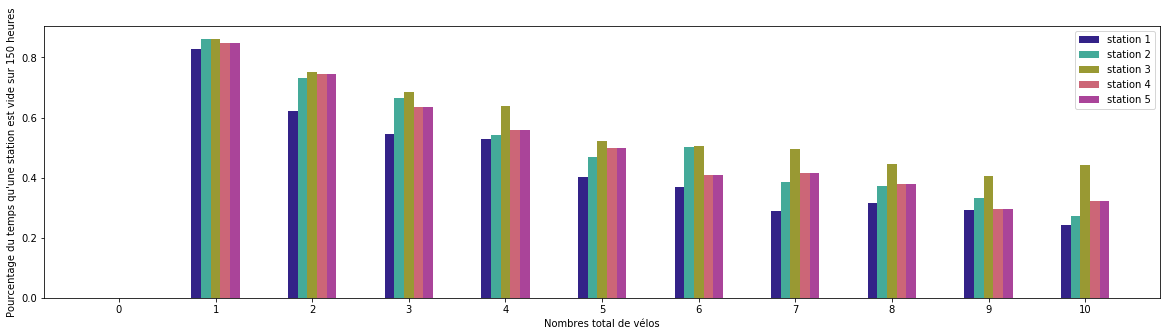

In [6]:
MigrationProcess.bike_number_impact(10) ## test with 70

On remarque que plus le nombre de vélos est important dans le système, plus la probabilité qu'une station soit vide est faible. De plus, plus il y a de vélos dans le système, plus les probabilités stationnaires entre les différentes stations se creuse. On observe ainsi que c'est la station 3 qui a le plus de chance d'être vide et que cette remarque devient de plus en plus flagrante plus le nombre de vélos dans le système est important.

## 4.2 Impact de la durée du processus sur l'obtention de la probabilité stationnaire

Regardons maintenant l'impact de la durée du processus sur l'obtention de la probabilité stationnaire avec 1 vélo. On rappelle qu'après 150 heures, la probabilité stationnaire semblaient être atteinte vu les résultats précédents. Chaque expérience est lancée 1000 fois. On regarde l'écart à la probabilité stationnaire en fonction du temps.

In [ ]:
MigrationProcess.process_duration_impact(50,theory) ## test with 40

On remarque que la probabilité stationnaire est atteinte assez rapidement. On observe qu'autour de 20 heures de processus, les différentes probabilités ne varient presque plus .